<a href="https://colab.research.google.com/github/kotech1/computervision/blob/master/13_funtopics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['figure.figsize'] = (8, 8)
mpl.rcParams['axes.grid'] = False


In [2]:
pretrained_model = tf.keras.applications.MobileNetV2(include_top=True,
                                                     weights='imagenet')
pretrained_model.trainable = False

# ImageNet 클래스 레이블
decode_predictions = tf.keras.applications.mobilenet_v2.decode_predictions

14540800/14536120 [==============================] - 0s 0us/step


In [3]:
# 이미지가 MobileNetV2에 전달될 수 있도록 전처리해주는 헬퍼 메서드(helper function)
def preprocess(image):
  image = tf.cast(image, tf.float32)
  image = image/255
  image = tf.image.resize(image, (224, 224))
  image = image[None, ...]
  return image

# 확률 벡터에서 레이블을 추출해주는 헬퍼 메서드
def get_imagenet_label(probs):
  return decode_predictions(probs, top=1)[0][0]


In [4]:


image_path = tf.keras.utils.get_file('YellowLabradorLooking_new.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')
image_raw = tf.io.read_file(image_path)
image = tf.image.decode_image(image_raw)

image = preprocess(image)
image_probs = pretrained_model.predict(image)


90112/83281 [================================] - 0s 0us/step


40960/35363 [==================================] - 0s 0us/step


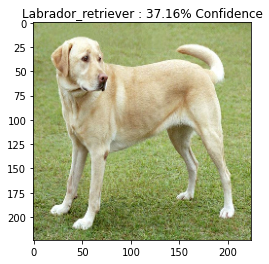

In [5]:
plt.figure()
plt.imshow(image[0])
_, image_class, class_confidence = get_imagenet_label(image_probs)
plt.title('{} : {:.2f}% Confidence'.format(image_class, class_confidence*100))
plt.show()


In [7]:
loss_object = tf.keras.losses.CategoricalCrossentropy()

def create_adversarial_pattern(input_image, input_label):
  with tf.GradientTape() as tape:
    tape.watch(input_image)
    prediction = pretrained_model(input_image)
    loss = loss_object(input_label, prediction)

  # 입력 이미지에 대한 손실 함수의 기울기를 구합니다.
  gradient = tape.gradient(loss, input_image)
  # 왜곡을 생성하기 위해 그래디언트의 부호를 구합니다.
  signed_grad = tf.sign(gradient)
  return signed_grad

(1000,)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


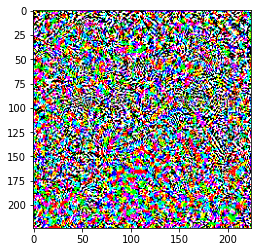

In [10]:
# 이미지의 레이블 위치만 1로 설정 (기본적인 클래스 분류기 결과)
labrador_retriever_index = 208
label = tf.one_hot(labrador_retriever_index, image_probs.shape[-1])
label = tf.reshape(label, (1, image_probs.shape[-1]))

# 공격 패턴 생성
perturbations = create_adversarial_pattern(image, label)
plt.imshow(perturbations[0])


In [9]:
image_probs.shape

(1, 1000)

In [11]:
# 인식하고 이미지 출력
def display_images(image, description):
  _, label, confidence = get_imagenet_label(pretrained_model.predict(image))
  plt.figure()
  plt.imshow(image[0])
  plt.title('{} \n {} : {:.2f}% Confidence'.format(description,
                                                   label, confidence*100))
  plt.show()


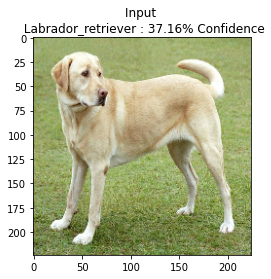

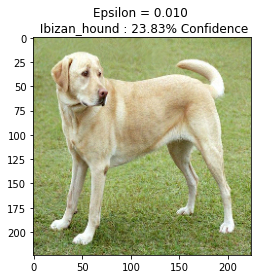

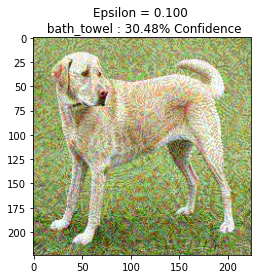

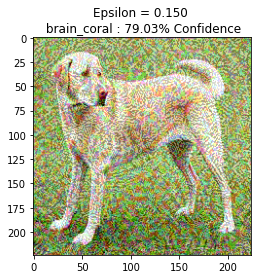

In [12]:
# epsilon을 변경하면서 결과 관찰
epsilons = [0, 0.01, 0.1, 0.15]
descriptions = [('Epsilon = {:0.3f}'.format(eps) if eps else 'Input')
                for eps in epsilons]

for i, eps in enumerate(epsilons):
  adv_x = image + eps*perturbations
  adv_x = tf.clip_by_value(adv_x, 0, 1)
  display_images(adv_x, descriptions[i])